# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import seaborn as sns
import scipy.stats as stats
from scipy.stats import gamma
from numpy.linalg import svd

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle


%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
email_counts = df['email'].value_counts().sort_values(ascending=False)
#email_counts.plot(kind='bar')
email_vals = email_counts.values


### Histogram of email counts

(array([4.388e+03, 4.320e+02, 1.540e+02, 7.900e+01, 2.900e+01, 2.800e+01,
        1.600e+01, 4.000e+00, 1.000e+00, 8.000e+00, 5.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00]),
 array([  1.  ,  15.52,  30.04,  44.56,  59.08,  73.6 ,  88.12, 102.64,
        117.16, 131.68, 146.2 , 160.72, 175.24, 189.76, 204.28, 218.8 ,
        233.32, 247.84, 262.36, 276.88, 291.4 , 305.92, 320.44, 334.96,
        349.48, 364.  ]),
 <a list of 25 Patch objects>)

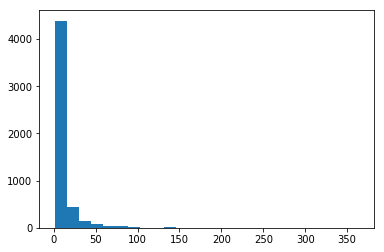

In [5]:
plt.hist(email_vals, bins = 25)

### Descriptive statistics of the email values

The shape of the email-counts data suggests a gamma distribution would be suitable.  A plot and the parameters of a gamma statisitcal model are as follows:

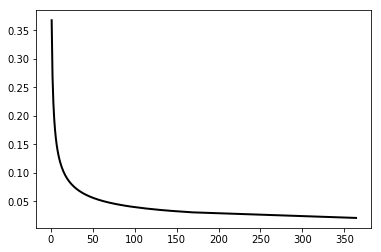

Gamma distribution parameters:
....
Mean: 8.930846930846931
Variance: 8.930846930846931
Skew: 0.6692427463101687
Kurtosis: 0.6718287802331652


In [6]:
gamma_dist = gamma(email_vals)
fig, ax = plt.subplots(1, 1)

ax.plot(email_vals, gamma_dist.pdf(email_vals), 'k-', lw=2, label='Email distribution')
plt.show()

a = email_counts.mean()
mean, var, skew, kurt = gamma.stats(a, moments='mvsk')

print('Gamma distribution parameters:')
print('....')
print('Mean: ' + str(mean))
print('Variance: ' + str(var))
print('Skew: ' + str(skew))
print('Kurtosis: ' + str(kurt))


In [7]:
len(email_counts)
email_counts[int(len(email_counts) /2)]

3

In [8]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Find and explore duplicate articles
df_content.shape

(1056, 5)

In [10]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id',], keep='first', inplace=True)
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
print("Num unique:" + str(df.article_id.nunique()))
print("Number of articles on the IBM platform: " + str(df_content.shape[0]))
print("Number of unique users: " + str(df.email.nunique()))
print("Number of user-article interactions: " + str(df.shape[0]))


Num unique:714
Number of articles on the IBM platform: 1051
Number of unique users: 5148
Number of user-article interactions: 45993


In [12]:
unique_articles = 714
total_articles = 1051
unique_users = 5148
user_article_interactions = 45993

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
df.article_id.value_counts().head(10)

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
Name: article_id, dtype: int64

In [14]:
df.article_id.value_counts().head(10)

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
Name: article_id, dtype: int64

In [15]:
most_viewed_article_id = str(1429.0)  # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [16]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [17]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [18]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    return df.title.value_counts().head(n).index.tolist()
    

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    return df.article_id.value_counts().head(n).index.tolist()
 


In [19]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [20]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [21]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    all_users = df['user_id'].unique()
    all_articles = df['article_id'].unique()
    
    user_item = pd.DataFrame(0, index=all_users, columns=all_articles)
    
    for index, row in df.iterrows():
        user_item.loc[ row['user_id'], row['article_id'] ] = 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

user_item.head(10)

,1430.0,1314.0,1429.0,1338.0,1276.0,1432.0,593.0,1185.0,993.0,14.0,...,1135.0,881.0,183.0,655.0,1233.0,1156.0,555.0,708.0,575.0,972.0
1,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,1,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [23]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    
    #keep the location of the row with the user_id we are checking against
    curr_user_row = user_item.loc[user_id]
    user_similarity = []
    
    for index, row in user_item.iterrows():
        if index != user_id:
            user_similarity.append((index, curr_user_row.dot(row)))           
    
   
    # sort by similarity
    sorted_by_similarity = sorted(user_similarity, reverse=True, key=lambda x: x[1])

    #print(sorted_by_similarity[:10])
    
    # create list of just the ids
    most_similar_users = [item[0] for item in sorted_by_similarity]
       
    # remove the own user's id
    #already done!
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [24]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [25]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = set()
    
    
    for title in df[df['article_id'].isin(article_ids)]['title']:
        article_names.add(title)
            
    
    return list(article_names) # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = []
    article_names = []
    
    user_row = user_item.loc[user_id]
    
    for article_id, interacted in user_row.iteritems():
        if interacted == 1:
            article_ids.append(str(article_id))
            #article_name = df_content[df_content['article_id'] == article_id].iloc[0]['doc_full_name']
            #article_names.append(name)    
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = set()
    
    similar_users = find_similar_users(user_id)
    
    for similar_user in similar_users:
        sim_user_articles, sim_user_names = get_user_articles(similar_user)
        for article in sim_user_names:
            if len(recs) < m:
                recs.add(article)
            else:
                return list(recs)
        
        #select arbitrarily
        for article in list(df_content['doc_full_name']):
            if len(recs) < m:
                recs.add(article)
            else:
                return list(recs)
  


In [26]:
#get_article_names(['1320.0', '232.0', '844.0'])
set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
#get_user_articles(20)[0]

True

In [27]:
# Check Results

# Return 10 recommendations for user 1
user_user_recs(1, 10)

['python if statements explained (python for data science basics #4)',
 'putting a human face on machine learning',
 'visualize car data with brunel',
 'uci: iris',
 'tensorflow quick tips',
 'time series prediction using recurrent neural networks (lstms)',
 'using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'sudoku',
 'predict loan applicant behavior with tensorflow neural networking']

In [28]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [29]:
user_item.loc[1].sum()

36

In [30]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    neighbors_df = pd.DataFrame(df['user_id'].unique().copy())
    neighbors_df.columns = ['neighbor_id'] 
    neighbors_df.drop(neighbors_df[neighbors_df.neighbor_id == user_id].index, inplace=True)
    neighbors_df['similarity'] = neighbors_df['neighbor_id'].apply(lambda x: user_item.loc[user_id].dot(user_item.loc[x]))
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda x: user_item.loc[x].sum())
         
    neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=[False, False], inplace = True)
    
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    neighbors_df = get_top_sorted_users(user_id)
    
    recs = set()
    rec_names = set()
    
    for index, row in neighbors_df.iterrows():
        similar_user = row['neighbor_id']
        
        sim_user_articles, sim_user_names = get_user_articles(similar_user)
        for index, article in enumerate(sim_user_articles):
            if len(recs) < m:
                recs.add(sim_user_articles[index])
                rec_names.add(sim_user_names[index])
            else:
                return list(recs), list(rec_names)        
    
    #return recs, rec_names

In [31]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1162.0', '1338.0', '1320.0', '1432.0', '1164.0', '1314.0', '1276.0', '1429.0', '12.0', '14.0']

The top 10 recommendations for user 20 are the following article names:
['putting a human face on machine learning', 'data structures related to machine learning algorithms', 'tensorflow quick tips', 'overlapping co-cluster recommendation algorithm (ocular)', 'an introduction to stock market data analysis with r (part 1)', 'this week in data science (may 23, 2017)', 'statistical bias types explained (with examples)', 'airbnb data for analytics: washington d.c. listings', 'analyze open data sets with pandas dataframes', 'use r dataframes & ibm watson natural language understanding']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [32]:
### Tests with a dictionary of results
print(get_top_sorted_users(1).iloc[0])
print(get_top_sorted_users(131).iloc[10])

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

#user131_10th_sim.iloc[1]

neighbor_id         3933
similarity            35
num_interactions      35
Name: 3932, dtype: int64
neighbor_id         242
similarity           25
num_interactions     59
Name: 241, dtype: int64


In [33]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Response:**

There is potential to use "most simialr users" to a user with no interactions.  This is because we have many users with only one interaction.  There may be a couple of articles that are most popular for new users to read as their first article.

If we wanted to improve this idea, we could keep track of the order in which users read articles, and then find the articles that occur most frequently at the top of users article lists when sorted chronologically.  This would find the articles that are most interesting to new users.

A simpler approach is just to take the most popular articles among all users.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [34]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs = []

for i in get_top_article_ids(10): 
    new_user_recs.append(str(i))



In [35]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.
... So I'm still going to do it.

In [36]:
import nltk
nltk.download('brown')
from textblob import TextBlob

[nltk_data] Downloading package brown to /home/ian/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [37]:
df_content.head(20)

def get_np(txt):
    '''
    INPUT:
    txt - source text
    
    OUTPUT:
    n_phrases - the noun phrases from the text
  
    '''
    blob = TextBlob(txt)
    n_phrases = blob.noun_phrases
    return n_phrases

df_content['keywords'] = df_content['doc_description'].apply(lambda x: get_np(str(x)))

In [38]:
for item in df_content['keywords'].head(30):
    print(str(item))

['detect', 'bad readings', 'real time', 'python', 'streaming analytics']
['data scientists', 'machine learning engineers', 'business obj…']
['’ s', 'week ’ s news', 'data', 'data']
['learn', 'dbs', 'persistent storage', 'introduce latency', 'data size increases', 'i/o']
['video demonstrates', 'ibm datascience experience', 'york', 'state restaurant', 'data scenario']
['compose', 'postgresql', 'data browser']
['upgrading', 'postgresql', 'compose', 'working', 'interesting process', 'postgresql', 'major upgrade']
['slack', 'data engineering', 'slack', 'ecosystem to…']
['kaggle', 'data science', 'learn', 'new skills', 'data scientists', 'world-class machine learning']
['o ’', 'reilly radar', 'o ’', 'reilly data', 'fang yu', 'data science', 'apache spark', 'subscribe', 'o ’', 'reilly…']
['apple', "'s sample app", 'tracker', 'sync data', 'offline-first design']
['replicating', 'relational dashdb database', 'sql', 'cloudant', '’ s', 'geojson', 'iot', 'store geospatial data', 'nosql', 'cloudant

In [39]:
def content_similarity(source_list, test_list):
    '''
    INPUT:
    source_list - a list of noun phrases from an aricle the user has read
    test_list - a list of noun phrases we want to compute similarity to
    
    OUTPUT:
    similarity_metric - an integer, 0 or greater, counting the number of shared noun phrases
  
    '''
    similarity_metric = 0
    for phrase in source_list:
        if(phrase in test_list):
            similarity_metric += 1
    
    return similarity_metric
    

In [40]:
#This is just exploratory analysis
for item in df_content['keywords'].head(30):
    sim_met = content_similarity(item, df_content['keywords'].iloc[1])
    print('Similarity: ' + str(sim_met))
    if(sim_met) > 0:
        print(str(item))
                                 

Similarity: 0
Similarity: 3
['data scientists', 'machine learning engineers', 'business obj…']
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 1
['kaggle', 'data science', 'learn', 'new skills', 'data scientists', 'world-class machine learning']
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 1
['’ s', '’ ve', 'data science notebooks', 'data scientists', 'high demand', 'python', 'jupyter…']
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 1
['want', 'data', 'experience', 'data scientists', 'lear ...']
Similarity: 0
Similarity: 0
Similarity: 0
Similarity: 0


In [41]:
def make_content_recs(user_id, m, df=df, user_item=user_item):
    '''
    INPUT:
    user_id : the user we are making recommendations for
    df, user_item: dataframes from the project
    m : gives the top m recommended articles
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    - Finds articles with matching noun phrases up to m
    - If m are not found, it fills up the list by recommending popular articles instead
 
    '''
    
    #will store recommendations as a <article_id: similarity score> dictionary
    recommendations = {}
    recs = []
    rec_names = []
    user_row = user_item.iloc[user_id]
    
    interacted_article_ids = []
    
    #look at all the user's articles and figure out the ones that have been interacted:
    for article_id, user_has_interacted in user_row.iteritems():
        if(user_has_interacted) != 0:            
            interacted_article_ids.append(int(article_id))
    
    #find the articles that are similar to the interacted articles
    for interacted_article in interacted_article_ids:
        if interacted_article in df_content.index:
            interacted_keywords = df_content['keywords'].iloc[interacted_article]

            for index, other_article in df_content.head(10).iterrows():      
                article_similarity = content_similarity(interacted_keywords, df_content['keywords'].iloc[index])

                #if the similarity is nonzero, and the user has not read the article
                if (index not in interacted_article_ids) & article_similarity > 0:
                    #update the recommendations dictionary if the similarity is better
                    if index not in recommendations:
                        recommendations[index] = article_similarity
                    if recommendations[index] < article_similarity:
                        recommendations[index] = article_similarity

    print(str(recommendations))
                        
    sorted_recs = sorted(recommendations.items(), key=lambda kv: kv[1], reverse = True)   

    for rec in sorted_recs:
        recs.append(rec[0])

    #slice recs to m if too long, or pad with popular articles if too short
    if len(sorted_recs) > m:
        recs = recs[0:m]
    else:
        num_recs_needed = m - len(recs)
        filler_recs = get_top_article_ids(num_recs_needed)
        recs = recs + filler_recs      

    print('Recs: ' + str(recs) + '  Length: ' + str(len(recs)) )
        
    #get article names
    rec_names = get_article_names(recs)
    
    return recs, rec_names

    
    

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

### Summary:

I extracted the noun phrases from a selection of article summaries, and this looked like it contianed a lot of key information.  I decided to use a comparison on this criterion.

To recommend *m* articles to a user:
 - For each article the user has read:
    - Compare the noun phrases in that article's summary to the noun phrases in all other articles. Count the matches.
    - For each other article, record the greatest number of noun phrase matches (a particular article may have matched with more than one of the user's articles).
 - Sort the articles by counts of matching noun phrases
 - If the count of matching articles is greater than *m*, recommend the top *m* articles found in this way
 - Otherwise, recommend the articles found in this way, along with enough articles recommended by popularity to bring the number of recomendations up to *m*.


### Changes
1.  As a first improvement, article_id in df does not seem to align well with article_id in df_content.  The length is not the same, the nomenclature is not the same, and there appear to be missing articles.  I would start by revisiting the data source and making sure the article_id fields were properly aligned.
2.  It has been demonstrated that NLP is able to extract technical terms from a body of text reasonably well. This technique could be used to extract keywords from the article body and recommend based on similarity.
3.  n-grams from headlines could be checked instead of noun phrases


`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [42]:
# make recommendations for a brand new user
test_recs, t_r_names = make_content_recs(1, 6)

print('Brand new user: ' + str(t_r_names))

# make a recommendations for a user who only has interacted with article id '1427.0'
#Not easy since I need a user id, but here is a user who has read some articles

test_recs, t_r_names = make_content_recs(100, 5)

print('Test user with article interations: ' + str(t_r_names))


{}
Recs: [1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0]  Length: 6
Brand new user: ['insights from new york car accident reports', 'predicting churn with the spss random tree algorithm', 'visualize car data with brunel', 'use deep learning for image classification', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'healthcare python streaming application demo']
{2: 1, 9: 1}
Recs: [2, 9, 1429.0, 1330.0, 1431.0]  Length: 5
Test user with article interations: ['insights from new york car accident reports', 'visualize car data with brunel', '3992    using apache spark to predict attack vectors a...\nName: title, dtype: object', 'use deep learning for image classification', 'this week in data science (april 18, 2017)']


*Note: the order of the recommended article names is not preserved since I used the function get_article_names, whch puts the data into a set (which is an unordered collection*


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [43]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [44]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [45]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = svd(user_item_matrix) # use the built in to get the three matrices

**Explanation:**

The lesson provides a data structure with numeric values representing a rating and nulls representing non-interaction.  This is not a matrix in the linear algebra sense and cannot be operated on (eg by SVD).  Funk SVD would have to be used to provide a numeric approximation.

The matrix in this exercise contains binary values with a zero representing non-interaction and a one representing interaction.  Although not invertible, this matrix can be factored by SVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

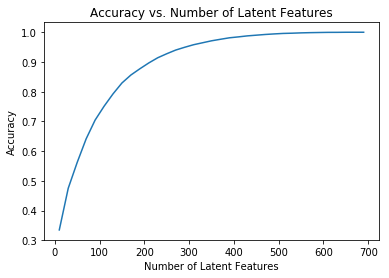

In [46]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [47]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # using create_user_item_matrix(df) from before:
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = df_test.drop_duplicates(subset='user_id', inplace = False)['user_id'].tolist()
    test_arts = df_test.drop_duplicates(subset='article_id', inplace = False)['article_id'].tolist()    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [48]:
print('How many users can we make predictions for in the test set?   ' + str(len(test_idx) - (df_test.iloc[df_test.shape[0] -1]['user_id'] - df_test.iloc[0]['user_id'])))
print('How many users in the test set are we not able to make predictions for because of the cold start problem? ' + str(len(set(df_test['user_id']).difference(set(df_train['user_id'])))))
print('How many articles can we make predictions for in the test set? ' + str(len(test_arts)))
print('How many articles in the test set are we not able to make predictions for because of the cold start problem?' + str(len(set(df_test['article_id']).difference(set(df_train['article_id'])))))




How many users can we make predictions for in the test set?   20
How many users in the test set are we not able to make predictions for because of the cold start problem? 662
How many articles can we make predictions for in the test set? 574
How many articles in the test set are we not able to make predictions for because of the cold start problem?0


In [49]:
###### NOTE TO REVIEWER:
## Initially, the function t.sol_4_test threw a key error:
##            KeyError: 'How many movies can we make predictions for in the test set?'
## The function seems to be looking for movies...
## After changing the keys in sol_4_dict, I got it to work

# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [50]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = svd(user_item_train)

# select row indices and columns that were found by the test-train split function
in_rows = [row for row in user_item_train.index.isin(test_idx)]
in_cols = [col for col in user_item_train.columns.isin(test_arts)]

u_test = u_train[in_rows]
vt_test = vt_train[:, in_cols]


In [51]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [52]:
#As discussed by (4), the test set allows for all of the aricles to be tested, but only 20 of the test users.

user_item_test_valid = user_item_test.loc[set(df_test['user_id']).intersection(set(df_train['user_id'])), set(user_item_test.columns).intersection(set(user_item_test.columns))]

user_item_test_valid



,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
3968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


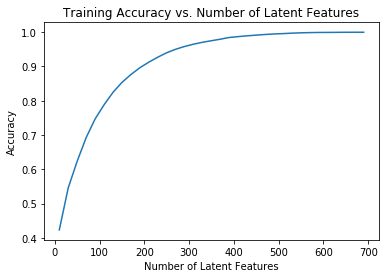

<function matplotlib.pyplot.show>

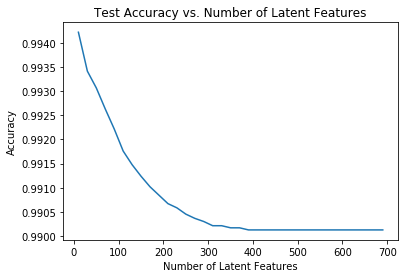

In [53]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure test matrices with k latent features
    s_train_restruct, u_train_restruct, vt_train_restruct = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_restruct, vt_test_restruct = u_test[:, :k], vt_test[:k, :]
    
    # take dot products
    train_est = np.around(np.dot(np.dot(u_train_restruct, s_train_restruct), vt_train_restruct))
    test_est = np.around(np.dot(np.dot(u_test_restruct, s_train_restruct), vt_test_restruct))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, train_est)
    diffs_test = np.subtract(user_item_test_valid, test_est)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Training Accuracy vs. Number of Latent Features');

plt.show()

plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Test Accuracy vs. Number of Latent Features');

plt.show

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

### Comment on results of previous question

I'm not convinced that a test set of 20 points gives a clear enough picture -- especially given the low interaction rates for most of the users.  The matrix is very sparse.  I might be more convinced if the testing were k-folded.

The test accuracy score declines from somewhere around 0.9942 to 0.9902, a difference in the third decimal place.  If the accuracy axis extended to zero, the change in accuracy would probably not be noticeable.  However, this may indicate that the model is slightly overfitting.

### How to determine if any of the recommenders are an improvement

As described in the video, the best way to evaluate the recommendation engines would be by measuring user behavior with and without the recommendation engine.  User engagement could be measured by increase in number of articles interacted with or increase in diversity of articles for example.  These matrics could be used to determine what recommendation method, or combined methods, work best for the user base.




<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [54]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0